# An example where a conventional RNN fails, due to a lack of symmetry

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import sys
from os import path

## Simulate Data
$m$ sequences each of length $\ell$ and binary class $y$.  
class $y\sim \text{Bernoulli}(0.5)$  

$$x=(x_1,\ldots, x_\ell)$$
$x_i \sim \text{Bernoulli}(0.5)$ (iid)
Falls $y_i=1$, setze
$$x[t..t+10) \leftarrow 1$$

In [10]:
ell = 100
m = 5000
siglen = 10

In [11]:
np.random.seed(13)

# development test data
def simulate_data(m, t):
    x = np.random.randint(2, size = m*ell).reshape(m, ell, 1)
    y = np.random.randint(2, size = m)
    for i in range(m):
        if y[i]:
            x[i, t:t + siglen, 0] = 1
    x = x - 0.5 # standardize
    return x, y

## Obtain the training set

In [12]:
regenerate = False
fname = "rnn-fail-data.npz"

if regenerate or not path.exists(fname):
    # simulate new data
    x, y = simulate_data(3, t=20)
    x = np.squeeze(x+.5).astype('int')
    print ("x ", x, "\ny", y)
    np.savez(fname, name1=x, name2=y)

x  [[0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
  1 0 0 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 0
  1 0 0 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1]
 [1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0
  1 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 0
  1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1]
 [0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0
  1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1
  0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0]] 
y [1 1 1]


In [ ]:
x, y = np.load(fname)

## Build the Model

In [5]:
def get_model(bidirectional = False, seqModelType = "SimpleRNN", units = 32):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(None,1)))

    if seqModelType == "LSTM":
        seqLayer = layers.LSTM(units)
    elif seqModelType == "GRU":
        seqLayer = layers.GRU(units)
    elif seqModelType == "SimpleRNN":
        seqLayer = layers.SimpleRNN(units)
    else:
        sys.exit("unknown sequence model type " + seqModelType)

    if bidirectional:
        seqLayer = layers.Bidirectional(seqLayer)
    
    model.add(seqLayer)
    model.add(layers.Dense(1))
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                  loss = tf.keras.losses.BinaryCrossentropy(), metrics = ["accuracy"])
    return model

In [6]:
model = get_model(bidirectional = True, seqModelType = "SimpleRNN", units = 32)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 64)                2176      
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


## Ad hoc fixed prediction method
$$ \hat{y} = 1 :\Leftrightarrow \exists j: x[j..j+10) = 1$$

In [7]:
def adhoc_pred(x):
    x = np.squeeze(x+.5).astype('int')
    A = np.cumsum(x, axis=1)
    B = np.zeros_like(A)
    B[:,siglen:] = A[:,:-siglen]
    yhat = np.any(A-B >= siglen, axis=1).astype('int')
    return yhat

In [8]:
def adhoc_acc(x_test, y_test):
    yhat = adhoc_pred(x_test)
    correct = (yhat == y_test).astype('int')
    return correct.mean()

## Train the Model

In [9]:
ts = np.array(range(ell - 15, -1, -10))
len(ts)

9

In [10]:
num_reps = 30
num_epochs = 2
modelnames = ["SimpleRNN", "LSTM", "GRU", "ad hoc"]
directions = [False, True] # bidirectional?
test_accs = { (name, direction) : np.empty((len(ts), num_reps)) for name in modelnames for direction in directions}

for modelname in modelnames:
    for direction in directions:
        print (modelname, direction, "\t", end = "")
        for j in range(len(ts)):
            print (j, " ", end = "")
            t = ts[j]
            accs = test_accs[(modelname, direction)]
            for r in range(num_reps):
                accuracy = 0.0
                x_test, y_test = simulate_data(1000, t)
                if modelname == "ad hoc":
                    accuracy = adhoc_acc(x_test, y_test)
                else:
                    model = get_model(bidirectional = direction, seqModelType = modelname, units = 32)
                    x_train, y_train = simulate_data(m, t)
                    x_val, y_val = simulate_data(100, t)

                    model.fit(x_train, y_train,
                          validation_data = (x_val, y_val), batch_size = 16, epochs = num_epochs, verbose=0)
                    
                    results = model.evaluate(x_test, y_test, batch_size = 16, verbose=0)
                    # print ("j=", j, "\tt=", t, "\tr=", r, "\tresults=", results)
                    accuracy = results[1]
                accs[j, r] = accuracy
        print ("\n", accs)

SimpleRNN False 	0  1  2  3  4  5  6  7  8  
 [[0.99299997 0.99699998 0.5        0.99599999 0.98199999 0.99800003
  0.99299997 0.95300001 0.99599999 0.98900002 0.98900002 0.972
  0.97299999 0.98900002 0.48899999 0.99800003 0.99800003 0.48899999
  0.99400002 0.99800003 0.76200002 0.99699998 0.99699998 0.99599999
  1.         0.99599999 0.49000001 0.98699999 0.99599999 0.995     ]
 [0.95599997 0.97600001 0.96799999 0.97100002 0.48800001 0.995
  0.91600001 0.92699999 0.71799999 0.97399998 0.991      0.99699998
  0.97600001 0.86799997 0.99000001 0.954      0.99199998 0.51300001
  0.99299997 0.99199998 0.98900002 0.89899999 0.98400003 0.96100003
  0.98799998 0.66500002 0.95300001 0.495      0.97000003 0.91900003]
 [0.47600001 0.493      0.49000001 0.94499999 0.917      0.97500002
  0.59100002 0.90399998 0.96499997 0.64399999 0.84200001 0.458
  0.49599999 0.81199998 0.51599997 0.45199999 0.97100002 0.97899997
  0.50800002 0.89700001 0.94599998 0.91799998 0.51099998 0.84899998
  0.98400003 0.

## Plot Results

Accuracy was averaged over 30 repetitions


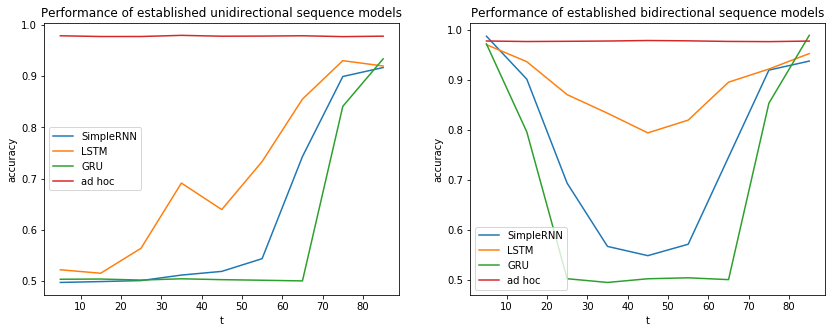

In [11]:
#  single plot
somemodelnames = ["SimpleRNN", "LSTM", "GRU", "ad hoc"]
fig, ax = plt.subplots(1,2, figsize=(14, 5))
for j, direction in enumerate(directions):
    for i, model in enumerate(somemodelnames):
        avg_test_acc = np.mean(test_accs[(model, direction)], axis = 1)
        ax[j].plot(ts, avg_test_acc, label = model)
    ax[j].set_title('Performance of established ' + ("bidirectional" if direction else "unidirectional") + " sequence models" )
    ax[j].set_xlabel("t")
    ax[j].set_ylabel("accuracy");
    ax[j].legend()
print ('Accuracy was averaged over ' + str(num_reps) + ' repetitions')
fig.savefig('failing1.pdf') 

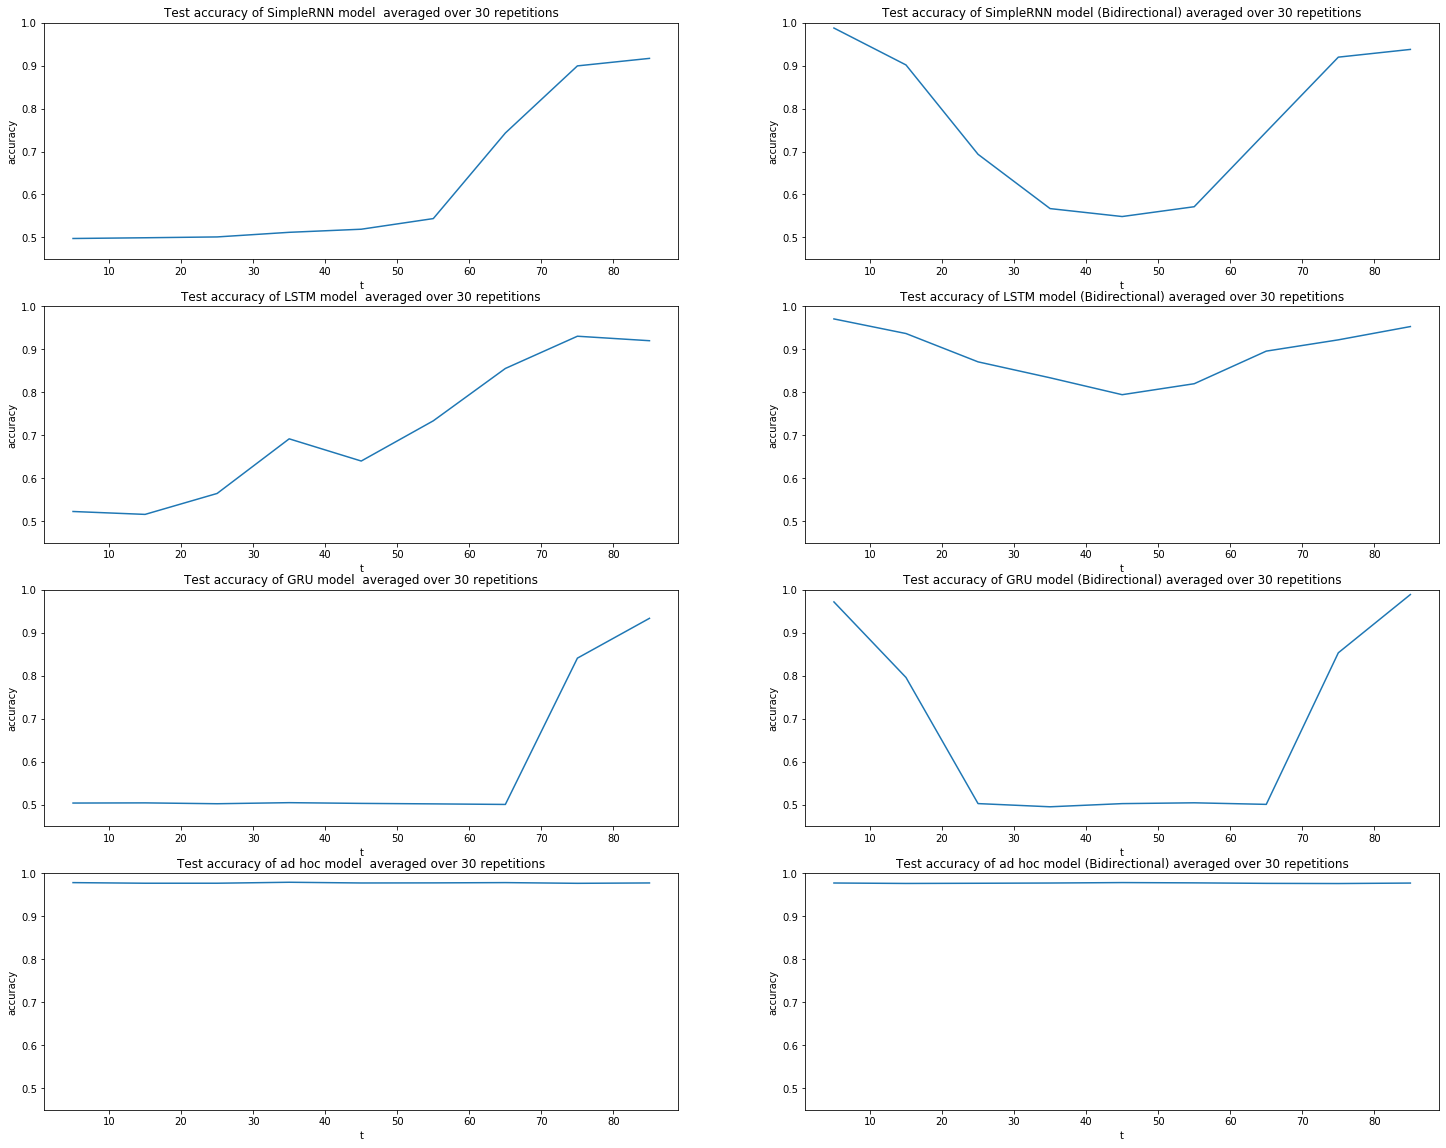

In [12]:
# one plot each
fig, ax = plt.subplots(len(modelnames),2, figsize=(25,20))
for i, model in enumerate(modelnames):
    for j, direction in enumerate(directions):
        avg_test_acc = np.mean(test_accs[(model, direction)], axis = 1)
        ax[i,j].plot(ts, avg_test_acc)
        ax[i,j].set_ylim([.45, 1])
        ax[i,j].set_title('Test accuracy of ' + model + ' model ' + ("(Bidirectional)" if direction else "") + ' averaged over ' + str(num_reps) + ' repetitions')
        ax[i,j].set_xlabel("t")
        ax[i,j].set_ylabel("accuracy");

In [13]:
fig.savefig('failing.pdf') 